In [1]:
from pathlib import Path
from typing import List, Optional, Dict, Union, Tuple
from dataclasses import dataclass
import itertools
import os

import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import polars as pl
from scipy.io import loadmat


from UnifiedMomentumModel import Momentum


# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

lesdir = Path(os.getcwd()) / "LES_data"
figdir = Path(os.getcwd()).parent / "fig"
figdir.mkdir(exist_ok=True, parents=True)

# Collect data to compare
Data to compared is collected in a dictionary of lists of `MomentumSolution` objects (`Dict[str, List[MomentumSolution]]`)

In [2]:
@dataclass
class ContourData:
    """
    Stores the Cp grid to be plotted in a contour plot.
    """

    yaw: ArrayLike  # 1D [deg]
    Ctprime: ArrayLike  # 1D
    Cp: ArrayLike  # 2D

    def data(self) -> Tuple[ArrayLike]:
        return self.yaw, self.Ctprime, self.Cp

    def power_maximising_setpoints(self) -> (ArrayLike, ArrayLike):
        return self.yaw, self.Ctprime[np.argmax(self.Cp, axis=1)]


# Set up results dictionary
results: Dict[str, ContourData] = {}

# Generate `classical` model data

In [3]:
Ctprimes = np.linspace(0, 4, 50)
yaws = np.linspace(0, 50, 51)
an = Ctprimes / (Ctprimes + 4)  # From C_T = 4a(1-a) and C_t = C_T' (1-a)^2


Ctprime_mesh, yaw_mesh = np.meshgrid(Ctprimes, yaws)
Cps = Ctprime_mesh * (1 - an) ** 3 * np.cos(np.deg2rad(yaw_mesh)) ** 3

results["classical"] = ContourData(yaws, Ctprimes, Cps)

# Generate `unified` momentum model Data

In [4]:
Ctprimes = np.linspace(0, 4, 50)
yaws = np.linspace(0, 50, 51)

Cps = np.zeros((len(yaws), len(Ctprimes)))
model = Momentum.UnifiedMomentum()

for i, yaw in enumerate(yaws):
    for j, Ctprime in enumerate(Ctprimes):
        sol = model(Ctprime, np.deg2rad(yaw))
        if np.isnan(sol.Cp):
            print(yaw, Ctprime)
        Cps[i, j] = sol.Cp

results["unified"] = ContourData(yaws, Ctprimes, Cps)

cache loaded


# Load `LES`

In [5]:
data = loadmat(lesdir / "Cp_les_contour_data.mat")

Ctprimes = data["ctp_les"][0]
yaws = data["yaw_les"][0]
Cps = np.minimum(data["cp_les"], 16 / 27)

results["LES"] = ContourData(yaws, Ctprimes, Cps)

# Plotting

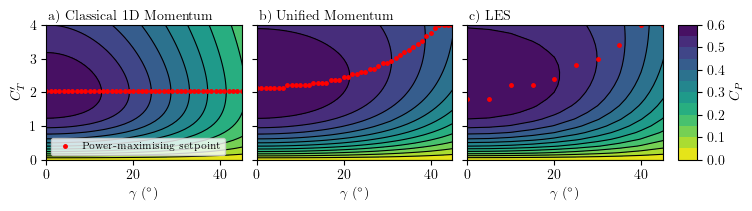

In [6]:
fig = plt.figure(figsize=0.7 * np.array((12, 2.5)))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.1)

axes = [plt.subplot(gs[0])]
axes.append(plt.subplot(gs[1], sharey=axes[0]))
axes.append(plt.subplot(gs[2], sharey=axes[0]))
plt.setp(axes[1].get_yticklabels(), visible=False)
plt.setp(axes[2].get_yticklabels(), visible=False)

levels = np.arange(0, 0.61, 0.05)

labels = {
    "classical": "a) Classical 1D Momentum",
    "unified": "b) Unified Momentum",
    "LES": "c) LES",
}
for key, ax in zip(["classical", "unified", "LES"], axes):
    yaw, Ctprime, Cp = results[key].data()
    CF = ax.contourf(yaw, Ctprime, Cp.T, levels=levels, cmap="viridis_r")
    CS = ax.contour(yaw, Ctprime, Cp.T, levels=levels, colors="k", linewidths=0.8)
    # ax.clabel(CS, inline=True, fontsize=10, fmt="%1.3f")

    ax.text(
        0.01,
        1 + 0.01,
        labels[key],
        ha="left",
        va="bottom",
        transform=ax.transAxes,
        # bbox=dict(boxstyle="square", ec="1", fc="1", alpha=0.5),
    )

    ax.plot(
        *results[key].power_maximising_setpoints(),
        "r.",
        ms=5,
        label="Power-maximising setpoint"
    )

    # ax.axhline(2, ls=":", c="r", lw=1)

    ax.set_xlabel("$\gamma$ ($^\circ$)")
    ax.set_xlim(0, 45)


axes[0].set_ylabel("$C_T'$")

axes[0].legend(loc="lower left", fontsize="x-small")

# Add colorbar to the rightmost axis
cax = plt.subplot(gs[3])
cbar = plt.colorbar(CF, cax=cax)
cbar.set_label(label=r"$C_P$")
plt.savefig(figdir / "Figure4_Cp_contour.png", dpi=500, bbox_inches="tight")